In [1]:
import sys
sys.path.append('../')

from nonlinear_system.ct_system import ContinuousTimeSystem
from nonlinear_system.epidem_odes import UIV
from moving_gauss import GaussEstimator
from lib.simulate import *
from lib.estimate import *
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.polynomial import Polynomial as Pol

In [2]:
verbose = False
verbose_lagrange = False

num_days = 30
sampling_dt = 0.5
integration_dt = 0.01

num_integration_steps = int(num_days/integration_dt)

uiv_ode = UIV(beta=1, p=2)
params = {}
params["beta"] = uiv_ode.beta
params["p"] = uiv_ode.p_p
params["c"] = uiv_ode.c
params['delta'] = uiv_ode.delta

In [3]:
n = uiv_ode.n
m = uiv_ode.m
p = uiv_ode.p

U0 = 4
V0 = 50e-8
# x0 = [U0, 0, 0]
x0 = [U0, 0, V0]

nderivs = uiv_ode.nderivs

N = 6           # Number of samples in a window
n_gauss = 5     # Number of Gaussian Functions

delay = 1

In [4]:
time, x, y_d, t_samples, y_samples = simulate(uiv_ode, x0, integration_dt, sampling_dt, num_days)

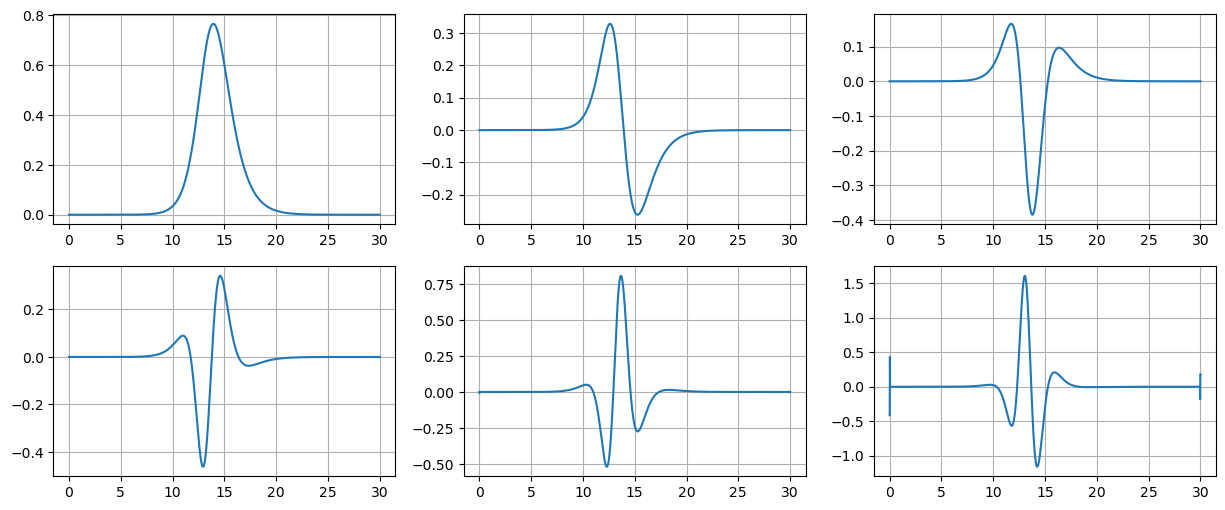

In [5]:
MAX_DERIVS = 5

y = y_d[0]
plt.figure(figsize=(15,6))
for i in range(MAX_DERIVS+1):
    plt.subplot(2,3,i+1)
    plt.plot(time, y)
    plt.grid()
    y = np.gradient(y, integration_dt)
plt.show()

In [6]:
Y_max = [0.8, 0.4, 0.5, 0.5, 0.9, 1.7]
y_hat, y_bound = get_gauss_estimates(t_samples, y_samples, Y_max, N, sampling_dt, n_gauss, delay, nderivs, integration_dt, d0=4)

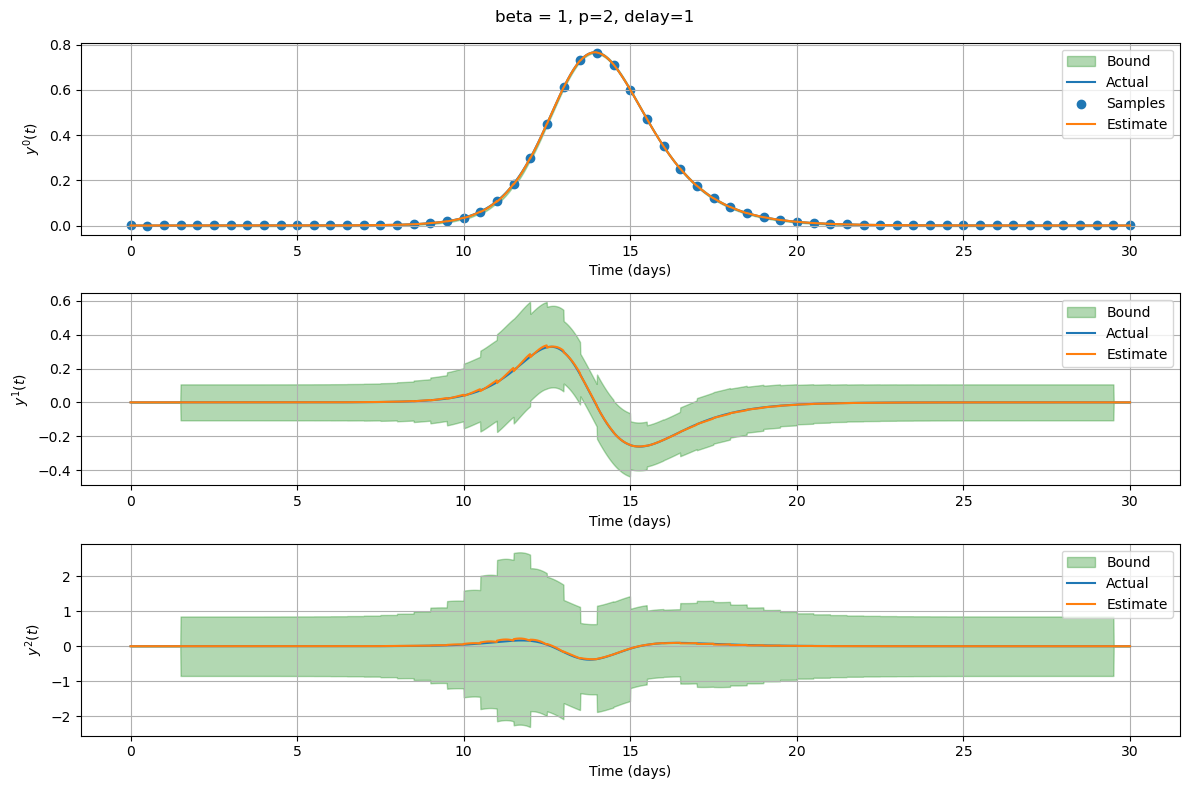

In [7]:
f2 = plt.figure("Output Derivatives", figsize=(12,8))
for derivs in range(nderivs):
    ax2 = f2.add_subplot(nderivs,1, derivs+1)
    ax2.fill_between(time, y_hat[derivs,:]-y_bound[derivs,:], y_hat[derivs,:]+y_bound[derivs,:], alpha=0.3, color='green', label='Bound')
    ax2.plot(time, y_d[derivs,:], label="Actual")
    if derivs==0:
        ax2.scatter(t_samples, y_samples, label="Samples")
    ax2.plot(time, y_hat[derivs,:], label="Estimate")
    ax2.grid()
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel(f"$y^{derivs}(t)$")
    ax2.legend()
f2.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f2.tight_layout()

plt.show()

In [8]:
states2 = ["V", "I", "UV"]

x2 = uiv_ode.invert_output2(t=0, y_d=y_d)
x2_hat = uiv_ode.invert_output2(t=0, y_d=y_hat)

x2_bound = np.zeros((nderivs, num_integration_steps+1))

x2_bound[0] = y_bound[0]
x2_bound[1] = (y_bound[1]+params['c']*y_bound[0])/params['p']
x2_bound[2] = (y_bound[2] + (params['c']+params['delta'])*y_bound[1] + params['c']*params['delta']*y_bound[0]) / (params['p']*params['beta'])

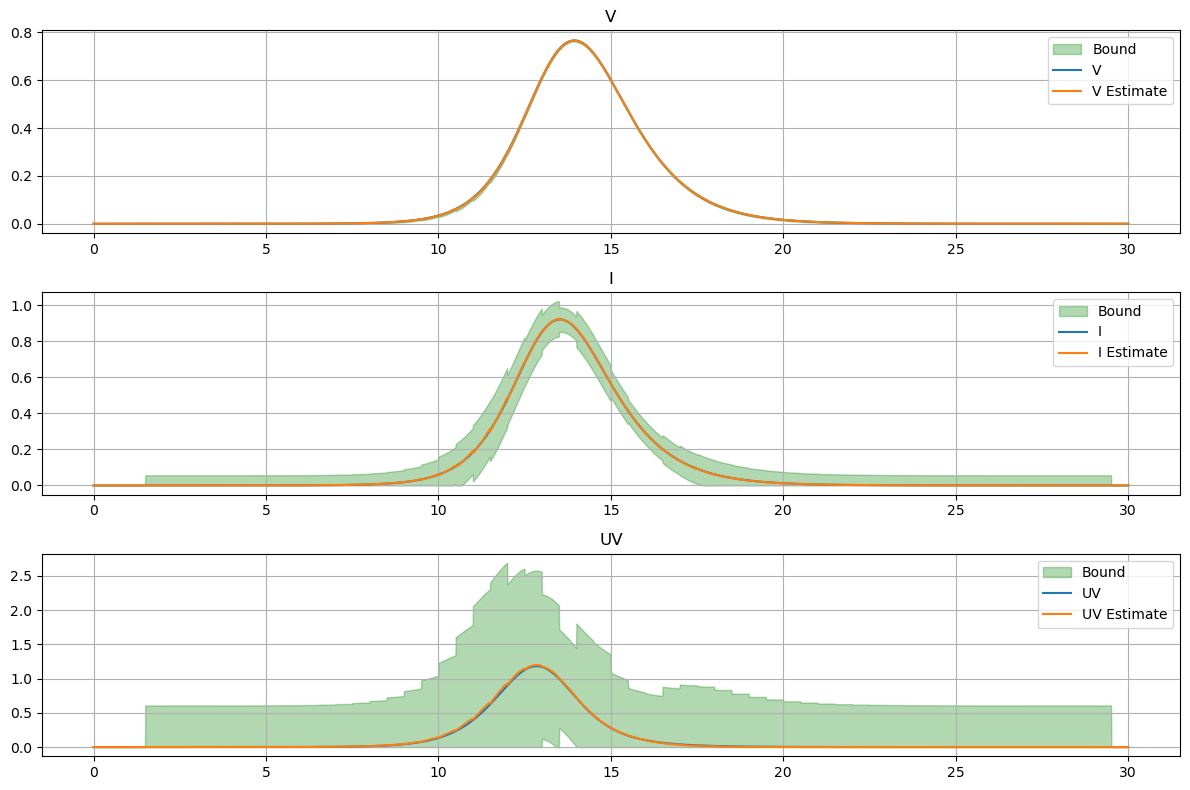

In [9]:
f3 = plt.figure("Transformed State Evolution", figsize=(12,8))
for i in range(n):
    ax = f3.add_subplot(n,1,i+1)
    ax.fill_between(time, np.maximum(0, x2_hat[i,:]-x2_bound[i,:]), x2_hat[i,:]+x2_bound[i,:], alpha=0.3, color='green', label='Bound')
    ax.plot(time, x2[i,:], label=states2[i])
    ax.plot(time, x2_hat[i,:], label=states2[i]+" Estimate")
    ax.set_title(states2[i])
    ax.grid()
    ax.legend()
# f3.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f3.tight_layout()

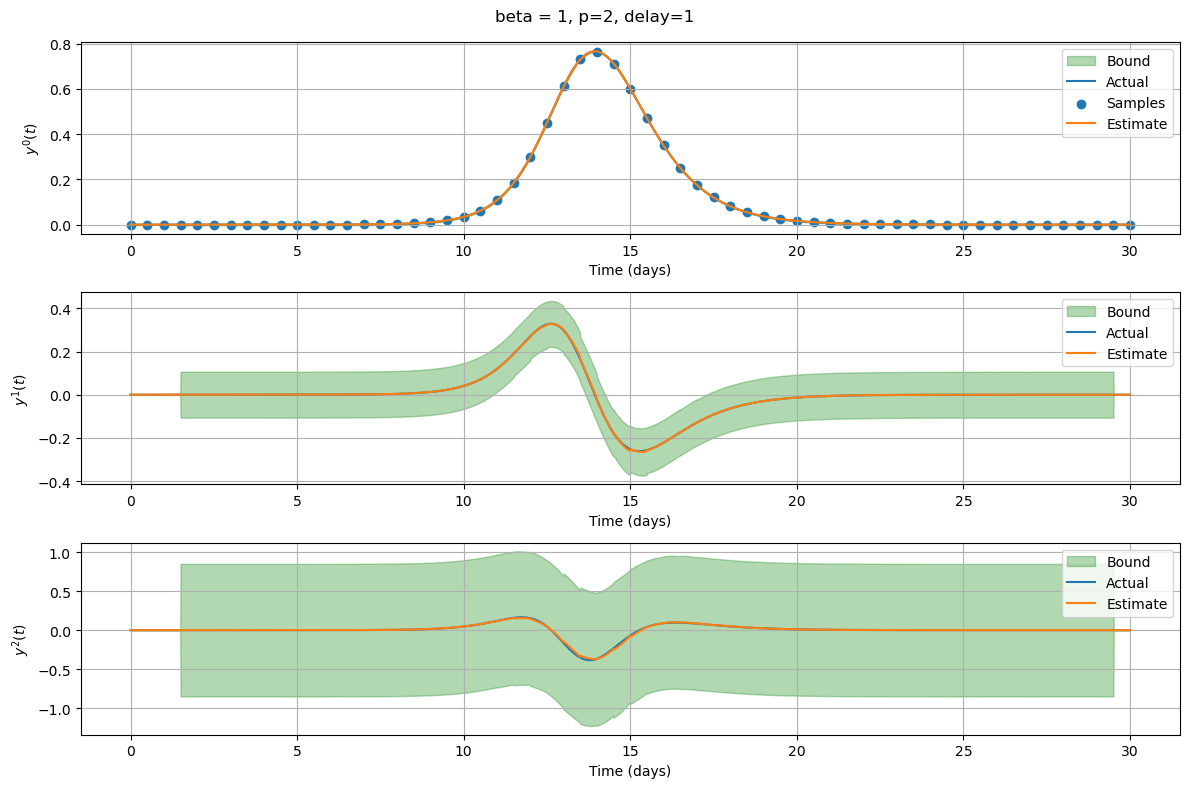

In [10]:
d=4

y_hat1, y_bound1 = get_poly_estimates(t_samples, y_samples, Y_max, N, sampling_dt, d, delay, nderivs, integration_dt)        

f2 = plt.figure("Output Derivatives", figsize=(12,8))
for derivs in range(nderivs):
    ax2 = f2.add_subplot(nderivs,1, derivs+1)
    ax2.fill_between(time, y_hat1[derivs,:]-y_bound1[derivs,:], y_hat1[derivs,:]+y_bound1[derivs,:], alpha=0.3, color='green', label='Bound')
    ax2.plot(time, y_d[derivs,:], label="Actual")
    if derivs==0:
        ax2.scatter(t_samples, y_samples, label="Samples")
    ax2.plot(time, y_hat1[derivs,:], label="Estimate")
    ax2.grid()
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel(f"$y^{derivs}(t)$")
    ax2.legend()
f2.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f2.tight_layout()

plt.show()

In [11]:
states2 = ["V", "I", "UV"]

x2 = uiv_ode.invert_output2(t=0, y_d=y_d)
x2_hat1 = uiv_ode.invert_output2(t=0, y_d=y_hat1)

x2_bound1 = np.zeros((nderivs, num_integration_steps+1))

x2_bound1[0] = y_bound1[0]
x2_bound1[1] = (y_bound1[1]+params['c']*y_bound1[0])/params['p']
x2_bound1[2] = (y_bound1[2] + (params['c']+params['delta'])*y_bound1[1] + params['c']*params['delta']*y_bound1[0]) / (params['p']*params['beta'])

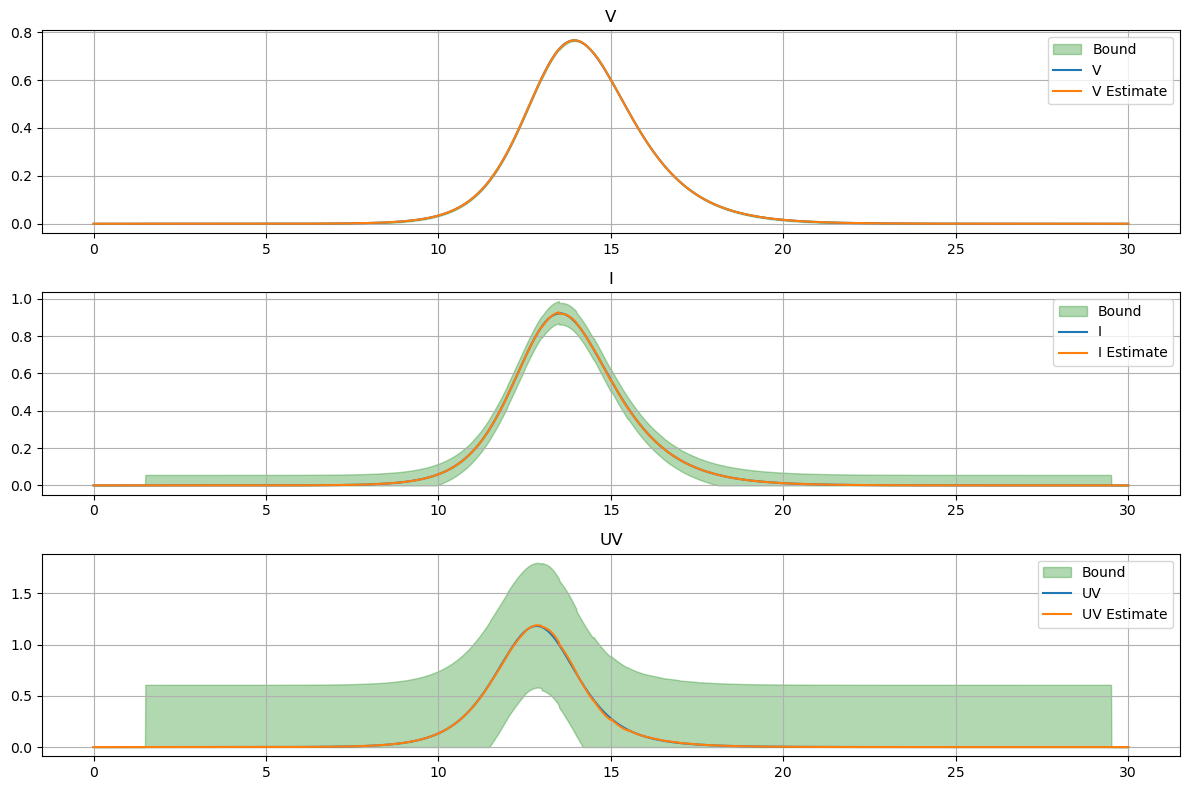

In [12]:
f3 = plt.figure("Transformed State Evolution", figsize=(12,8))
for i in range(n):
    ax = f3.add_subplot(n,1,i+1)
    ax.fill_between(time, np.maximum(0, x2_hat1[i,:]-x2_bound1[i,:]), x2_hat1[i,:]+x2_bound1[i,:], alpha=0.3, color='green', label='Bound')
    ax.plot(time, x2[i,:], label=states2[i])
    ax.plot(time, x2_hat1[i,:], label=states2[i]+" Estimate")
    ax.set_title(states2[i])
    ax.grid()
    ax.legend()
# f3.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f3.tight_layout()